In [137]:
from abc import ABC, abstractmethod
from heapq import heappush as push
from heapq import heappop as pop
import math
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
class Nodo:
    id_nodo = -1

    @classmethod
    def incr_id_nodo(cls):
        cls.id_nodo += 1
        return cls.id_nodo

    def __init__(self,estado=None,padre=None,accion=None,costo=0):
        self.id = self.incr_id_nodo()
        self.estado = estado
        self.padre = padre
        self.accion = accion
        self.costo = costo


class Busqueda:

    def __init__(self, problema=None):
        self.problema = problema
        self.tree = nx.DiGraph()
        self.solucion = None
        self.sol_path_nodes = None
        self.sol_path_edges = None
        self.search_routine = None
        self.pos = None


    def iter_sol(self, mode='nodes', nodo=None):

        if nodo:
            pass
        else:
            nodo = self.solucion
        sol_path = [nodo.id]
        if nodo:
            nodo_padre = nodo.padre
            while nodo_padre:
                sol_path.append(nodo_padre.id)
                nodo = nodo_padre
                nodo_padre = nodo.padre
        sol_path = sol_path[::-1]

        if mode=='nodes':
            pass
        if mode=='edges':
            sol_path = [(sol_path[i], sol_path[i + 1]) for i in range(len(sol_path) - 1)]

        return sol_path


    def create_node(self, **kwargs):
        node = Nodo(**kwargs)
        self.tree.add_node(node.id, obj=node)
        return node


    def build_tree(self):
        nodes = self.tree.nodes
        for node in nodes:
            padre = nodes[node]['obj'].padre
            if padre:
                self.tree.add_edge(padre.id, node, accion=nodes[node]['obj'].accion)


    def draw_tree(self, node_size=300, node_color="#FFFFFF", font_size=12, draw_edge_labels=False, edge_labels=None, alpha=0.):
        nodes = self.tree.nodes
        root = list(filter(lambda n: nodes[n]['obj'].estado.id == self.problema.s0.id, nodes))[0]
        if self.solucion:
            solution = list(filter(lambda n: nodes[n]['obj'].id == self.solucion.id, nodes))[0]
        else:
            solution = 'no_solution'
        pos = graphviz_layout(self.tree, prog='dot')
        pos = {int(k): pos[k] for k in pos}
        self.pos = pos
        n_lbls = {node: self.tree.nodes[node]['obj'].estado.id for node in self.tree.nodes}
        node_color = [{root: '#85c2ce', solution: '#61c398'}.get(n, node_color) for n in nodes]
        node_alpha = [{root: 1., solution: 1.}.get(n, alpha) for n in nodes]
        edge_color = ['#61c398' if e in self.sol_path_edges else '#000000' for e in self.tree.edges]

        nx.draw_networkx_nodes(self.tree, pos, node_color=node_color, alpha=node_alpha, node_size=node_size)
        nx.draw_networkx_edges(self.tree, pos, edge_color=edge_color, node_size=node_size)
        nx.draw_networkx_labels(self.tree, pos, labels=n_lbls, font_size=font_size)

        if draw_edge_labels:
            edges = self.tree.edges
            if not edge_labels:
                edge_labels = {edge: edges[edge]['accion'] for edge in edges}
            nx.draw_networkx_edge_labels(self.tree, pos=pos, edge_labels=edge_labels)


    def estado_nodo(self, nodo):
        return self.tree.nodes[nodo]['obj'].estado.id


    def solve(self, problema=None):
        if problema is None:
            problema = self.problema
        solucion = self.search_routine(problema)
        self.solucion = solucion
        self.sol_path_nodes = self.iter_sol('nodes')
        self.sol_path_edges = self.iter_sol('edges')
        return solucion


class ProblemaBusqueda(ABC):

    @abstractmethod
    def acc_posibles(self):
        pass

    @abstractmethod
    def transicion(self):
        pass

    @abstractmethod
    def costo(self):
        pass

    @abstractmethod
    def es_factible(self):
        pass

In [139]:
class BFS(Busqueda):

    def __init__(self, problema=None):
        Busqueda.__init__(self, problema)
        self.search_routine = self.BFS

    def expand_bfs(self, problema, nodo):
        s0 = nodo.estado
        for accion in problema.acc_posibles(s0):
            s = problema.transicion(s0, accion)
            costo = nodo.costo + problema.costo(s0, accion, s)
            yield self.create_node(estado=s, padre=nodo, accion=accion, costo=costo)

    def BFS(self, problema):
        nodo = self.create_node(estado=problema.s0)
        frontera = []
        push(frontera, (nodo.costo, nodo.id, nodo))
        alcanzados = {nodo.estado.id: nodo}
        while frontera:
            nodo = pop(frontera)[2]
            if problema.es_factible(nodo.estado):
                return nodo
            for hijo in self.expand_bfs(problema, nodo):
                s = hijo.estado
                if s.id not in alcanzados or hijo.costo < alcanzados[s.id].costo:
                    alcanzados[s.id] = hijo
                    push(frontera, (hijo.costo, hijo.id, hijo))
        return




In [140]:
class DFS(Busqueda):

    def __init__(self, problema=None):
        Busqueda.__init__(self, problema)
        self.search_routine = self.DFS

    def expand_dfs(self, problema, nodo):
        s0 = nodo.estado
        for accion in problema.acc_posibles(s0):
            s = problema.transicion(s0, accion)
            costo = nodo.costo - 1
            yield self.create_node(estado=s, padre=nodo, accion=accion, costo=costo)

    def DFS(self, problema):
        nodo = self.create_node(estado=problema.s0)
        frontera = [nodo]
        alcanzados = {nodo.estado.id: nodo}
        while frontera:
            nodo = frontera.pop()
            if problema.es_factible(nodo.estado):
                return nodo
            for hijo in self.expand_dfs(problema, nodo):
                s = hijo.estado
                if s.id not in alcanzados:
                    alcanzados[s.id] = hijo
                    frontera.append(hijo)
        return


In [141]:
class GBFS(Busqueda):

    def __init__(self, problema, heuristica):
        Busqueda.__init__(self, problema)
        self.heuristica = heuristica
        self.search_routine = self.GBFS

    def expand_gbfs(self, problema, nodo):
        s0 = nodo.estado
        for accion in problema.acc_posibles(s0):
            s = problema.transicion(s0, accion)
            costo = nodo.costo + problema.costo(s0, accion, s)
            yield self.create_node(estado=s, padre=nodo, accion=accion, costo=costo)

    def GBFS(self, problema):
        nodo = self.create_node(estado=problema.s0)
        frontera = []
        push(frontera, (self.heuristica(nodo.estado.id), nodo.id, nodo))
        alcanzados = {nodo.estado.id: nodo}
        while frontera:
            nodo = pop(frontera)[2]
            if problema.es_factible(nodo.estado):
                return nodo
            for hijo in self.expand_gbfs(problema, nodo):
                s = hijo.estado
                if s.id not in alcanzados or hijo.costo < alcanzados[s.id].costo:
                    alcanzados[s.id] = hijo
                    push(frontera, (self.heuristica(nodo.estado.id), hijo.id, hijo))
        return
    
    
    def draw_tree(self, show_heuristic=True, xh_align=0, yh_align=0,font_color='k',**kwargs):    
        Busqueda.draw_tree(self,**kwargs)
        if show_heuristic:
            nodes = self.tree.nodes
            labels = {n:str(self.heuristica(nodes[n]['obj'].estado.id)) for n in nodes}                           
            
            pos = self.pos
            if xh_align or yh_align: 
                pos = {k:(v[0]+xh_align, v[1]+yh_align) for k,v in pos.items()}
            nx.draw_networkx_labels(self.tree,
                                    pos=pos,
                                    labels=labels,
                                    font_color=font_color)
               

In [142]:
class AStar(Busqueda):

    def __init__(self, problema, heuristica):
        Busqueda.__init__(self, problema)
        self.heuristica = heuristica
        self.search_routine = self.AStar

    def expand_AStar(self, problema, nodo):
        s0 = nodo.estado
        for accion in problema.acc_posibles(s0):
            s = problema.transicion(s0, accion)
            costo = nodo.costo + problema.costo(s0, accion, s)
            yield self.create_node(estado=s, padre=nodo, accion=accion, costo=costo)

    def AStar(self, problema):
        nodo = self.create_node(estado=problema.s0)
        frontera = []
        push(frontera, (self.heuristica(nodo.estado.id)+nodo.costo, nodo.id, nodo))
        alcanzados = {nodo.estado.id: nodo}
        while frontera:
            nodo = pop(frontera)[2]
            if problema.es_factible(nodo.estado):
                return nodo
            for hijo in self.expand_AStar(problema, nodo):
                s = hijo.estado
                if s.id not in alcanzados or hijo.costo < alcanzados[s.id].costo:
                    alcanzados[s.id] = hijo
                    push(frontera, (self.heuristica(nodo.estado.id)+nodo.costo, hijo.id, hijo))
        return
    
    
    def draw_tree(self, show_heuristic=True, xh_align=0, yh_align=0,font_color='k',show_cost=True,**kwargs):    
        Busqueda.draw_tree(self,**kwargs)
        if show_heuristic:
            nodes = self.tree.nodes
            labels = {n:str(self.heuristica(nodes[n]['obj'].estado.id)) for n in nodes}                           
            
            pos = self.pos
            if xh_align or yh_align: 
                pos = {k:(v[0]+xh_align, v[1]+yh_align) for k,v in pos.items()}
            nx.draw_networkx_labels(self.tree,
                                    pos=pos,
                                    labels=labels,
                                    font_color=font_color)
        if show_cost:
            nodes = self.tree.nodes
            labels = {n:str(nodes[n]['obj'].costo) for n in nodes}                           
            
            pos = self.pos
            if xh_align or yh_align: 
                pos = {k:(v[0]+xh_align+7, v[1]+yh_align) for k,v in pos.items()}
                
            nx.draw_networkx_labels(self.tree,
                                    pos=pos,
                                    labels=labels,
                                    font_color='blue')
    

### Problema 5

In [143]:
class EstadoProblemaGrafica:
    def __init__(self, name):
        self.id = name
        
    def __str__(self):
        return self.id

class ProblemaGrafica(ProblemaBusqueda):
    
    def __init__(self,grafica,s0,F,cost_att='weight'):
        self.G = G
        self.cost_att = []
        self.s0 = s0
        self.F = F
        self.cost_att.append(cost_att)

    
    def acc_posibles(self,estado):
        n_s0 = list(filter(lambda e: e[0]==estado.id,G.edges(data=True)))
        acc = []
        for e in n_s0:
            for k in e[2].keys():
                if k in self.cost_att:
                    acc.append((e[1],k))
        return acc
        
    
    def transicion(self, estado, accion):
        if accion in self.acc_posibles(estado):
            return EstadoProblemaGrafica(accion[0])
        else:
            None
        
        
    def costo(self,s,a,ns):
        return G[s.id][ns.id][a[1]]
    
    
    def es_factible(self,estado):
        F_ids = [s.id for s in self.F]
        return estado.id in F_ids
    
    
    def __str__(self):
        return self.grafica.__str__()        

In [144]:
# Para definir el mundo de esta grafica vamos a definir una grafica con networkx
G = nx.DiGraph()
G.add_nodes_from(["s0","s1","s2","s3","s4","s5","s6","s7"])
G.add_edges_from([
    ("s0", "s2", {'weight':1,'dist':2}),
    ("s0", "s1", {'weight':2,'dist':2}),
    ("s2", "s3", {'weight':2,'dist':2}),
    ("s1", "s3", {'weight':5,'dist':2}),
    ("s3", "s4", {'weight':3,'dist':2}),
    ("s3", "s5", {'weight':1,'dist':2}),
    ("s4", "s5", {'weight':1,'dist':2}),
    ("s4", "s6", {'weight':1,'dist':2}),
    ("s5", "s6", {'weight':2,'dist':2}),
    ("s5", "s7", {'weight':4,'dist':2})
     ])

s0 = EstadoProblemaGrafica("s0")
sf = EstadoProblemaGrafica("s6")
F = [sf]
p_grafica = ProblemaGrafica(G,s0,F)

Profundidad de la solucion: 4
Solucion: [0, 2, 3, 5, 6]


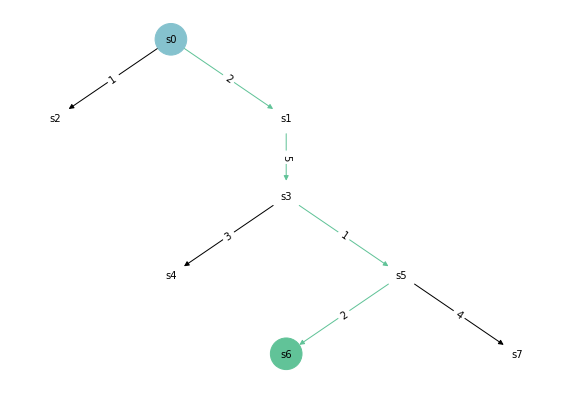

In [145]:
dfs = DFS(p_grafica)
solucion = dfs.solve()
print("Profundidad de la solucion:", abs(solucion.costo))
print("Solucion:", dfs.sol_path_nodes)
dfs.build_tree()
# Construimos el diccionario de edges para anotarlos en la grafica
t_edges = dfs.tree.edges
t_nodes = dfs.tree.nodes
g_edges = p_grafica.G.edges
edge_labels = {}
for e in t_edges:
    g_like_edge = tuple([t_nodes[n]['obj'].estado.id for n in e])
    edge_labels[e] = g_edges[g_like_edge]['weight']
fig, ax = plt.subplots(figsize=(10, 7))
dfs.draw_tree(node_size=1000,font_size=10,draw_edge_labels=True, edge_labels=edge_labels)
_ = plt.axis('off')

### Problema 6

In [146]:
class Room():
    
    directions = ['up','down','left','right']
    
    def __init__(self, name):
        self.name = name
        self.connections = {}
        
    def add_connection(self,direction,room):
        if direction in self.directions:
            self.connections[direction] = room
        else:
            print(f"Direcciones permitidas: {self.directions}")
    
    def __str__(self):
        return self.name+":"+str(list(self.connections.items()))


In [147]:
class EstadoMundoAspiradora():
    
    @classmethod
    def make_id(cls,dirt,pos_agente):
        s = [str(dirt[k]) for k in sorted(dirt.keys())]
        s.append(str(pos_agente))
        s = "("+','.join(s)+")"
        #s += str(pos_agente)
        return s
    
    def __init__(self, dirt, pos_agente):
        self.id = self.make_id(dirt,pos_agente) 
        self.dirt = dirt
        self.pos_agente = pos_agente
        
    def __str__(self):
        return self.id
    

In [148]:
class MundoAspiradora(ProblemaBusqueda):
    
    actions = ['up','down','left','right','suck']
    
    @classmethod
    def build_world(cls,rooms):
        if rooms:
            return {room.name:room for room in rooms}
        else:
            return {}
    
    def __init__(self,rooms,s0,F):
        self.rooms = self.build_world(rooms)
        self.s0 = s0
        self.F = F
    
    def acc_posibles(self,estado):
        room = self.rooms[estado.pos_agente]
        actions = list(room.connections.keys())
        actions.append('suck')
        return actions
        
    
    def transicion(self, estado, accion):
        dirt = estado.dirt.copy()
        if accion == 'suck':
            dirt[estado.pos_agente] = 0
            return EstadoMundoAspiradora(dirt=dirt,pos_agente=estado.pos_agente)
        else:
            next_room = self.rooms[estado.pos_agente].connections.get(accion)
            if next_room:
                return EstadoMundoAspiradora(dirt=dirt,pos_agente=next_room)
            else:
                return estado
    
    
    def costo(self,*args):
        return 1
    
    
    def es_factible(self,estado):
        F_str = [str(s) for s in self.F]
        return str(estado) in F_str
    
    
    def __str__(self):
        str_rooms = ''
        for a in self.rooms:
            conn = self.rooms[a].connections
            for b in conn:
                str_rooms += f"{a} {b} {conn[b]}\n"
        return str_rooms

In [149]:
# Creamos las habitaciones con sus conexiones
room_A = Room(name='A')
room_B = Room(name='B')
room_C = Room(name='C')
room_A.add_connection('right','B')
room_A.add_connection('down','C')
room_B.add_connection('left','A')
room_C.add_connection('up','A')
rooms = [room_A,room_B,room_C]

# Definimos el estado inicial
s0 = EstadoMundoAspiradora({'A':1,'B':1,'C':1},'A')

# Definimos los estados objetivo
room_names = [r.name for r in rooms]
F = [EstadoMundoAspiradora({rn:0 for rn in room_names},pos) for pos in room_names]

# Creamos el ambiente
mundo = MundoAspiradora(rooms,s0,F)

Profundidad de la solucion: 6
Solucion: [8, 9, 13, 19, 29, 40, 50]


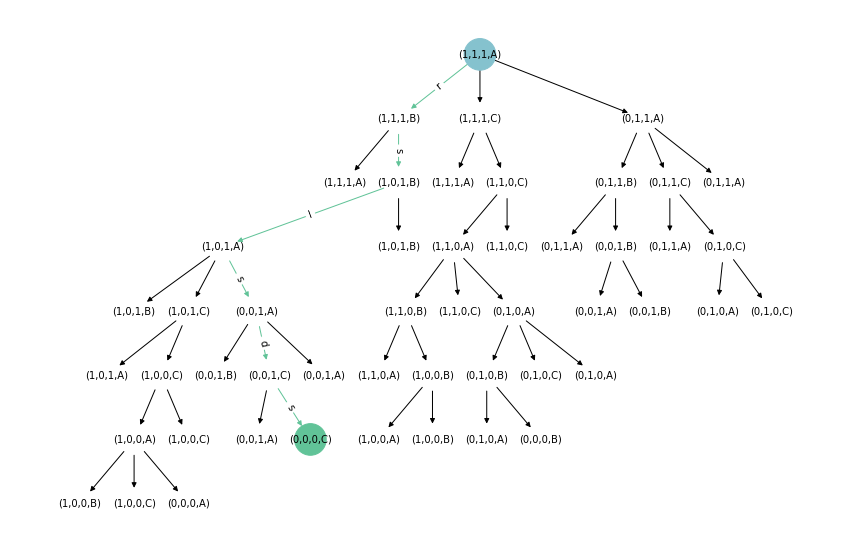

In [150]:
bfs = BFS(mundo)
solucion = bfs.solve()
print("Profundidad de la solucion:", abs(solucion.costo))
print("Solucion:", bfs.sol_path_nodes)
bfs.build_tree()

# Construimos el diccionario de edges para anotarlos en la grafica
edges = bfs.tree.edges
edge_labels = {e: edges[e]['accion'][0] for e in edges if e in bfs.sol_path_edges}

fig, ax = plt.subplots(figsize=(15, 10))
bfs.draw_tree(node_size=1000,font_size=10,draw_edge_labels=True,edge_labels=edge_labels)
_ = plt.axis('off')

### Problema 7

Costo de la solucion: 7
Solucion: ['s0', 's2', 's3', 's4', 's6']


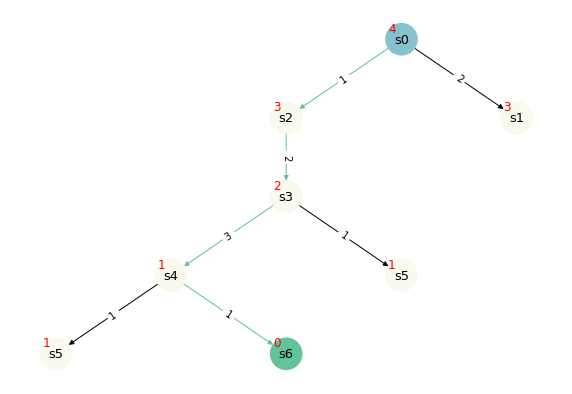

In [151]:
heuristica = lambda x: {"s0":4,"s1":3,"s2":3,"s3":2,"s4":1,"s5":1,"s6":0,"s7":math.inf}.get(x)
gbfs = GBFS(p_grafica,lambda x: heuristica(x))
solucion = gbfs.solve()
print("Costo de la solucion:", abs(solucion.costo))
print("Solucion:", [gbfs.estado_nodo(n) for n in gbfs.sol_path_nodes])
gbfs.build_tree()
# Construimos el diccionario de edges para anotarlos en la grafica
t_edges = gbfs.tree.edges
t_nodes = gbfs.tree.nodes
g_edges = p_grafica.G.edges
edge_labels = {}
for e in t_edges:
    g_like_edge = tuple([t_nodes[n]['obj'].estado.id for n in e])
    edge_labels[e] = g_edges[g_like_edge]['weight']
fig, ax = plt.subplots(figsize=(10, 7))
gbfs.draw_tree(node_size=1000,
               node_color="beige",
               alpha = 0.5,
               font_size=13,
               draw_edge_labels=True,
               edge_labels=edge_labels,
               show_heuristic=True,
               xh_align=-3,yh_align=10,
               font_color="red")
_ = plt.axis('off')

### Problema 8

Costo de la solucion: 6
Solucion: ['s0', 's2', 's3', 's5', 's6']


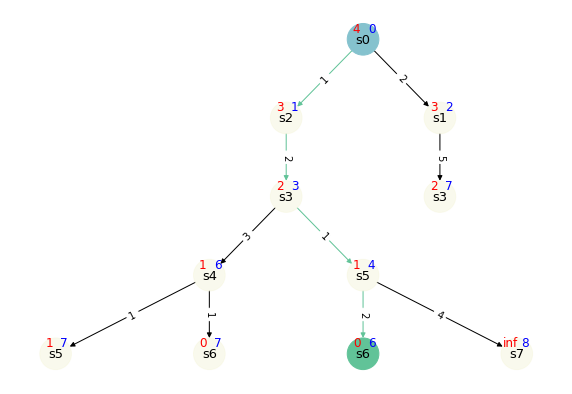

In [152]:
heuristica = lambda x: {"s0":4,"s1":3,"s2":3,"s3":2,"s4":1,"s5":1,"s6":0,"s7":math.inf}.get(x)
a_star = AStar(p_grafica,lambda x: heuristica(x))
solucion = a_star.solve()
print("Costo de la solucion:", abs(solucion.costo))
print("Solucion:", [a_star.estado_nodo(n) for n in a_star.sol_path_nodes])
a_star.build_tree()
# Construimos el diccionario de edges para anotarlos en la grafica
t_edges = a_star.tree.edges
t_nodes = a_star.tree.nodes
g_edges = p_grafica.G.edges
edge_labels = {}
for e in t_edges:
    g_like_edge = tuple([t_nodes[n]['obj'].estado.id for n in e])
    edge_labels[e] = g_edges[g_like_edge]['weight']
fig, ax = plt.subplots(figsize=(10, 7))
a_star.draw_tree(node_size=1000,
               node_color="beige",
               alpha = 0.5,
               font_size=13,
               draw_edge_labels=True,
               edge_labels=edge_labels,
               show_heuristic=True,
               xh_align=-3,yh_align=10,
               font_color="red")
_ = plt.axis('off')

### Problema 9

In [153]:
# Para definir el mundo de esta grafica vamos a definir una grafica con networkx
G = nx.DiGraph()
G.add_nodes_from(["s0","s1","s2","s3","s4","s5","s6"])
G.add_edges_from([
    ("s0", "s1", {'weight':1}),
    ("s0", "s2", {'weight':2}),
    ("s1", "s3", {'weight':5}),
    ("s3", "s6", {'weight':1}),
    ("s2", "s4", {'weight':2}),
    ("s4", "s2", {'weight':1}),
    ("s4", "s6", {'weight':4}),
    ("s2", "s5", {'weight':3}),
    ("s5", "s6", {'weight':1})
])

s0 = EstadoProblemaGrafica("s0")
sf = EstadoProblemaGrafica("s6")
F = [sf]
p_grafica = ProblemaGrafica(G,s0,F)

Costo de la solucion: 6
Solucion: ['s0', 's2', 's5', 's6']


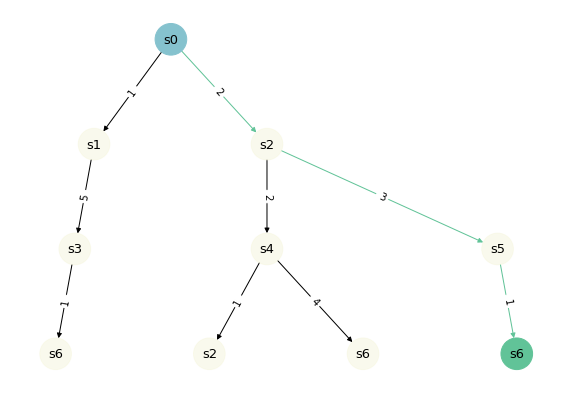

In [154]:
bfs = BFS(p_grafica)
solucion = bfs.solve()
print("Costo de la solucion:", abs(solucion.costo))
print("Solucion:", [bfs.estado_nodo(n) for n in bfs.sol_path_nodes])
bfs.build_tree()
# Construimos el diccionario de edges para anotarlos en la grafica
t_edges = bfs.tree.edges
t_nodes = bfs.tree.nodes
g_edges = p_grafica.G.edges
edge_labels = {}
for e in t_edges:
    g_like_edge = tuple([t_nodes[n]['obj'].estado.id for n in e])
    edge_labels[e] = g_edges[g_like_edge]['weight']
fig, ax = plt.subplots(figsize=(10, 7))
bfs.draw_tree(node_size=1000,
              node_color="beige",
              alpha=0.5,
              font_size=13,
              draw_edge_labels=True,
              edge_labels=edge_labels)
_ = plt.axis('off')

### Problema 10

Costo de la solucion: 7
Solucion: ['s0', 's1', 's3', 's6']


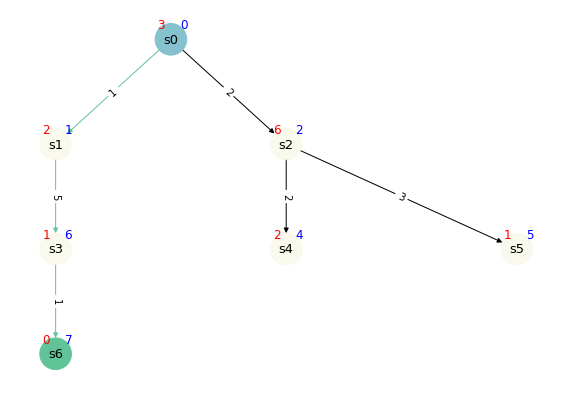

In [155]:
heuristica = lambda x: {"s0":3,"s1":2,"s2":6,"s3":1,"s4":2,"s5":1,"s6":0}.get(x)
a_star = AStar(p_grafica,lambda x: heuristica(x))
solucion = a_star.solve()
print("Costo de la solucion:", abs(solucion.costo))
print("Solucion:", [a_star.estado_nodo(n) for n in a_star.sol_path_nodes])
a_star.build_tree()
# Construimos el diccionario de edges para anotarlos en la grafica
t_edges = a_star.tree.edges
t_nodes = a_star.tree.nodes
g_edges = p_grafica.G.edges
edge_labels = {}
for e in t_edges:
    g_like_edge = tuple([t_nodes[n]['obj'].estado.id for n in e])
    edge_labels[e] = g_edges[g_like_edge]['weight']
fig, ax = plt.subplots(figsize=(10, 7))
a_star.draw_tree(node_size=1000,
               node_color="beige",
               alpha = 0.5,
               font_size=13,
               draw_edge_labels=True,
               edge_labels=edge_labels,
               show_heuristic=True,
               xh_align=-3,yh_align=10,
               font_color="red")
_ = plt.axis('off')